tgb - 8/18/2019 - The goal is to calculate smooth linear reponse functions about the base state used for Noah's paper and for 2 different neural networks:  
1) One that exhibit stable behavior once coupled to CAM (Stable NN) 
2) One that does not (Unstable NN)  
We will take the following steps:  
1) Perturb the base state with normally-distributed perturbations at each level  
2) Calculate the linear response of each perturbed profile  
3) Average the linear response to get the final linear response  
4) Save the perturbed profiles and the perturbed response, as well as their average for Noah  
5) Use eigenvalue analysis to see how the averaging affect the stability of the response. We will use 3 types of stability analysis:  
5.1) Stability of the coupled (T,q) system, all normalized to energy units  
5.2) Stability of the (q) system on its own  
5.3) Stability of the (T,q) system reduced to a single q system via the WTG approximation (see Beucler and Cronin, 2018)

# 1) Initialization

Define imports

In [24]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.utils import *
from cbrain.normalization import *
from cbrain.models import fc_model
import matplotlib.pyplot as plt
from numpy import linalg as LA
import pickle
import scipy.integrate as sin
from tensorflow.python.ops.parallel_for.gradients import batch_jacobian
%matplotlib inline

Define neural networks

In [2]:
in_vars = ['QBP', 'TBP', 'VBP', 'PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ', 'TPHYSTND', 'FSNT', 'FSNS', 'FLNT', 'FLNS', 'PRECT']

In [3]:
scale_dict = load_pickle('../../nn_config/scale_dicts/002_pnas_scaling.pkl')

Define input and output transform

In [4]:
CAMDIR = '/scratch/05488/tg847872/revision_debug/'
input_transform = InputNormalizer(
    xr.open_dataset(f'{CAMDIR}/001_norm.nc'),
    in_vars,
    'mean', 'maxrs')

In [5]:
output_transform = DictNormalizer(xr.open_dataset(CAMDIR+'001_norm.nc'), 
                                  out_vars, scale_dict)

Load stable and unstable NNs

In [6]:
model = fc_model(66, 65, [256]*9, 'LeakyReLU')
model.load_weights(
    f'{CAMDIR}weights.h5'
)

In [7]:
STABLENN_path = '/home1/05823/tg851228/006_8col_pnas_exact/'
UNSTABNN_path = '/home1/05823/tg851228/007_32col_pnas_exact/'

stabNN = fc_model(94, 65, [256]*9, 'LeakyReLU')
stabNN.load_weights(
    f'{STABLENN_path}weights.h5'
)

unstabNN = fc_model(94, 65, [256]*9, 'LeakyReLU')
unstabNN.load_weights(
    f'{UNSTABNN_path}weights.h5'
)

# 2) Load and perturb Noah's tropical profiles

Load Noah's dataset for base tropical profile

In [8]:
path = '/home1/05823/tg851228/NC_DATA/2019-05-01-tropical_mean.nc'
noah_ds = xr.open_mfdataset(path, decode_times=False, concat_dim='time')

Load CAM dataset for coordinates used in CAM

In [9]:
cam_ds = xr.open_mfdataset(CAMDIR+ 'debug.cam2.h1.*.nc', decode_times=False, concat_dim='time')

Calculate rho and z from ideal gas law and hydrostasy

In [19]:
# Height [m]
Z_INTERP = np.interp(cam_ds.lev.values,np.fliplr(noah_ds.p.values)[0,:],
                       np.flip(noah_ds.z.values))
# Interface height [m]
ZI_INTERP = np.interp(cam_ds.ilev.values,np.fliplr(noah_ds.p.values)[0,:],
                       np.flip(noah_ds.z.values))
# Density [kg/m3]
RHO_INTERP = np.interp(cam_ds.lev.values,np.fliplr(noah_ds.p.values)[0,:],
                       np.flip(noah_ds.rho.values)[0,:])
# Specific humidity [kg/kg]
NNQBP = 1e-3*np.interp(cam_ds.lev.values,np.fliplr(noah_ds.p.values)[0,:],
                       np.fliplr(noah_ds.QV.values)[0,:])
# Temperature [K]
NNTBP = np.interp(cam_ds.lev.values,np.fliplr(noah_ds.p.values)[0,:],
                  np.fliplr(noah_ds.TABS.values)[0,:])
# Meridional velocity [m/s]
NNVBP = np.interp(cam_ds.lev.values,np.fliplr(noah_ds.p.values)[0,:],
                  np.fliplr(noah_ds.V.values)[0,:])
# Surface pressure [Pa]
NNPS = 1e2*noah_ds.p.values[:,0]
# Solar insolation [W/m2]
NNSOLIN = noah_ds.SOLIN.values
# Sensible heat flux [W/m2]
NNSHF = noah_ds.SHF.values
# Latent heat flux [W/m2]
NNLHF = noah_ds.LHF.values

Calculate rho and z from ideal gas law and hydrostasy

In [49]:
# Ideal gas law -> rho=p(R_d*T_v)
eps = 0.622 # Ratio of molecular weight(H2O)/molecular weight(dry air)
R_D = 287 # Specific gas constant of dry air in J/K/kg

r = NNQBP/(NNQBP**0-NNQBP)
Tv = NNTBP*(r**0+r/eps)/(r**0+r)
RHO = 1e2*cam_ds.lev.values/(R_D*Tv)

Z = -sin.cumtrapz(x=1e2*cam_ds.lev.values,y=1/(G*RHO))
Z = np.concatenate((np.zeros(1,),Z))
Z = Z-Z[-1]+Z_INTERP[-1]

For interface levels, first interpolate the temperature and specific humidity before infering the interface geopotential heights

In [53]:
qvI = 1e-3*np.interp(cam_ds.ilev.values,np.fliplr(noah_ds.p.values)[0,:],
                     np.fliplr(noah_ds.QV.values)[0,:])
TI = np.interp(cam_ds.ilev.values,np.fliplr(noah_ds.p.values)[0,:],
               np.fliplr(noah_ds.TABS.values)[0,:])

rI = qvI/(qvI**0-qvI)
TvI = TI*(rI**0+rI/eps)/(rI**0+rI)
RHOI = 1e2*cam_ds.ilev.values/(R_D*TvI)

ZI = -sin.cumtrapz(x=1e2*cam_ds.ilev.values,y=1/(G*RHOI))
ZI = np.concatenate((np.zeros(1,),ZI))
ZI = ZI-ZI[-1]+ZI_INTERP[-1]

Save them in a vector called base state

In [55]:
base_state = {}
base_state['qv'] = NNQBP
base_state['T'] = NNTBP
base_state['v'] = NNVBP
base_state['ps'] = NNPS
base_state['S0'] = NNSOLIN
base_state['SHF'] = NNSHF
base_state['LHF'] = NNLHF
base_state['p'] = cam_ds.lev.values
base_state['p_interface'] = cam_ds.ilev.values
base_state['z'] = Z
base_state['z_interface'] = ZI
base_state['rho'] = RHO
base_state['rho_interface'] = RHOI

In [56]:
# Variables that we will perturb 
profiles = {'qv','T','v'}
scalars = {'ps','S0','SHF','LHF'}

Perturb profiles and scalars

In [57]:
# We perturb each variable using a normal distribution of mean 0 and standard deviation 10%
Np = np.size(base_state['p']) # Number of vertical levels
Npert = 1000 # Number of perturbations
pert_state = {};

for i,profile in enumerate(profiles):
    print('i=',i,' profile=',profile,'          ',end='\r')
    pert_state[profile] = np.zeros((Np,Npert))
    
    for j,lev in enumerate(base_state['p']):
        #print('j=',j,' level=',lev)
        pert_state[profile][j,:] = base_state[profile][j]+\
        np.random.normal(loc=0,scale=0.1,size=(Npert,))*np.tile(base_state[profile][j],(Npert,))

In [58]:
for i,scalar in enumerate(scalars):
    print('i=',i,' scalar=',scalar,'          ',end='\r')
    pert_state[scalar] = base_state[scalar]+\
        np.random.normal(loc=0,scale=0.1,size=(Npert,))*np.tile(base_state[scalar],(Npert,))

Check that the perturbation follows a normal distribution

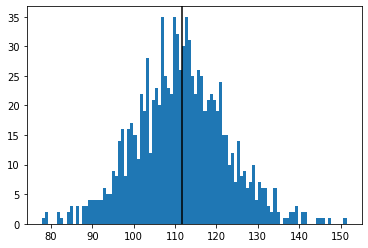

In [59]:
plt.hist(pert_state['LHF'],bins=100)
plt.axvline(x=base_state['LHF'],color='k')

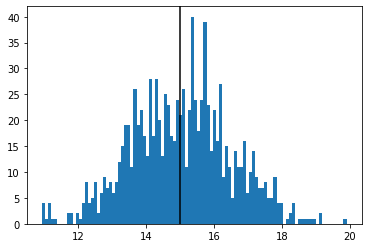

In [60]:
plt.hist(1e3*pert_state['qv'][28],bins=100)
plt.axvline(x=1e3*base_state['qv'][28],color='k')

# 3) Calculate the linear response of each perturbed profile, and compare the mean linear response function to the linear response function of the mean

Define the functions to get single jacobian and jacobian in a batch

In [61]:
def get_jacobian(x, model):
    sess = tf.keras.backend.get_session()
    jac = jacobian(model.output, model.input)
    J = sess.run(jac, feed_dict={model.input: x.astype(np.float32)[None]})
    return J.squeeze()
def get_batch_jacobian(x, model):
    sess = tf.keras.backend.get_session()
    jac = batch_jacobian(model.output, model.input)
    J = sess.run(jac, feed_dict={model.input: x.astype(np.float32)})
    return J.squeeze()

Create input vectors to feed to the neural network

In [62]:
in_vec = np.concatenate([base_state['qv'],
                         base_state['T'],
                         base_state['v'],
                         base_state['ps'],
                         base_state['S0'],
                         base_state['SHF'],
                         base_state['LHF'],
                        ])[None, :].astype('float32')

In [63]:
in_vec_pert = np.concatenate([pert_state['qv'],
                              pert_state['T'],
                              pert_state['v'],
                              np.tile(pert_state['ps'],(1,1)),
                              np.tile(pert_state['S0'],(1,1)),
                              np.tile(pert_state['SHF'],(1,1)),
                              np.tile(pert_state['LHF'],(1,1)),
                             ])[None, :].astype('float32')
in_vec_pert = np.transpose(in_vec_pert[0,:,:]) # Shape = [#batches,input size]

Define normalization for inputs and outputs

In [64]:
cf_inp = np.zeros((1,94))
for index in range (94):
    if index<30: cf_inp[0,index]=L_V;
    elif index<60: cf_inp[0,index]=C_P;
    else: cf_inp[0,index]=1;
        
cf_oup = np.zeros((1,65))
for index in range (65):
    if index<30: cf_oup[0,index]=L_V;
    elif index<60: cf_oup[0,index]=C_P;
    else: cf_oup[0,index]=1;

Use the get_batch_jacobian function to calculate linear responses about all perturbed states

In [65]:
Jstab = get_batch_jacobian(input_transform.transform(in_vec_pert),stabNN)*\
np.transpose(cf_oup/output_transform.scale)/\
(cf_inp*input_transform.div)

In [66]:
Junstab = get_batch_jacobian(input_transform.transform(in_vec_pert),unstabNN)*\
np.transpose(cf_oup/output_transform.scale)/\
(cf_inp*input_transform.div)

In [67]:
LRFstab = Jstab[:,:(2*Np),:(2*Np)] # Only keep the d(dq/dt,dT/dt)/d(q,T) Jacobian
LRFunstab = Junstab[:,:(2*Np),:(2*Np)] # Only keep the d(dq/dt,dT/dt)/d(q,T) Jacobian

In [68]:
LRFstab_mean = np.mean(LRFstab,axis=0)
LRFunstab_mean = np.mean(LRFunstab,axis=0)

Plot the mean linear response for both the stable and unstable cases

Case # 1 Stable
Case # 2 Unstable


<Figure size 480x320 with 0 Axes>

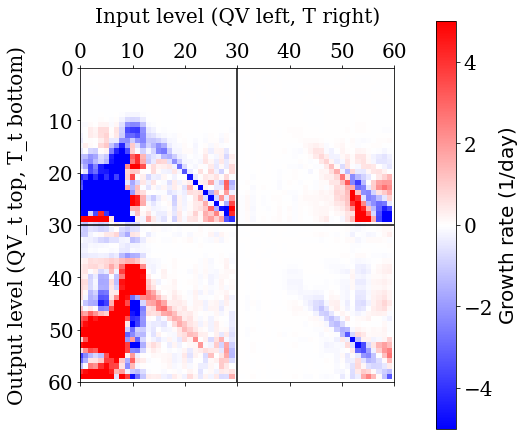

<Figure size 480x320 with 0 Axes>

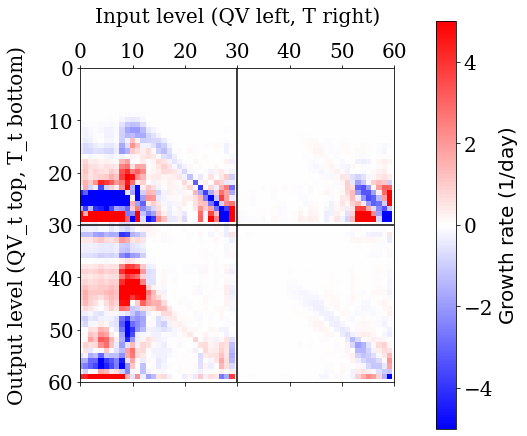

In [69]:
plt.rc('font', family='serif')

for ifig in range(2):
    plt.figure(num=None,dpi=80, facecolor='w', edgecolor='k')
    fig, ax = plt.subplots(figsize=(7.5,7.5))
    
    if ifig==0: toplot = 24*3600*LRFstab_mean; case = 'Stable'
    elif ifig==1: toplot = 24*3600*LRFunstab_mean; case = 'Unstable'
    print('Case #',ifig+1,case)
    cax = ax.matshow(toplot,cmap='bwr', vmin=-5, vmax=5)

    x = np.linspace(0.,60.,100);

    plt.plot(x,Np*x**0, color='k')
    plt.plot(Np*x**0,x, color='k')
    plt.xlim((0,2*Np)); plt.ylim((2*Np,0))

    cbar = fig.colorbar(cax, pad = 0.1)
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'$\mathrm{Growth\ rate\ \left(1/day\right)}$',\
                   rotation=90, fontsize = 20)

    plt.xticks(fontsize=20); plt.yticks(fontsize=20)
    ax.xaxis.set_label_position('top')
    X = plt.xlabel(r'Input level (QV left, T right)', fontsize = 20)
    ax.xaxis.labelpad = 20
    Y = plt.ylabel(r'Output level (QV_t top, T_t bottom)', fontsize = 20)
    ax.yaxis.labelpad = 20

Compare to linear response of the mean

In [70]:
Jstab = get_batch_jacobian(input_transform.transform(in_vec),stabNN)*\
np.transpose(cf_oup/output_transform.scale)/\
(cf_inp*input_transform.div)

In [71]:
Junstab = get_batch_jacobian(input_transform.transform(in_vec),unstabNN)*\
np.transpose(cf_oup/output_transform.scale)/\
(cf_inp*input_transform.div)

In [72]:
LRFmean_stab = Jstab[:(2*Np),:(2*Np)] # Only keep the d(dq/dt,dT/dt)/d(q,T) Jacobian
LRFmean_unstab = Junstab[:(2*Np),:(2*Np)] # Only keep the d(dq/dt,dT/dt)/d(q,T) Jacobian

Case # 1 Stable
Case # 2 Unstable


<Figure size 480x320 with 0 Axes>

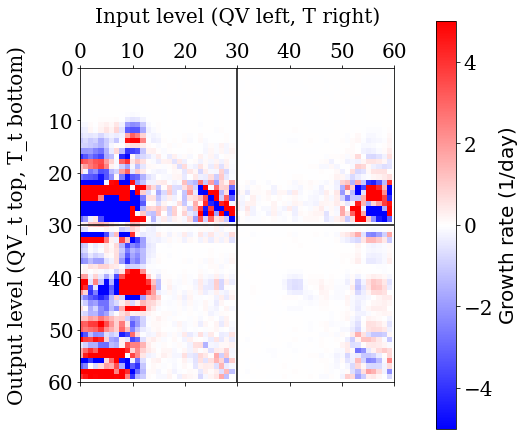

<Figure size 480x320 with 0 Axes>

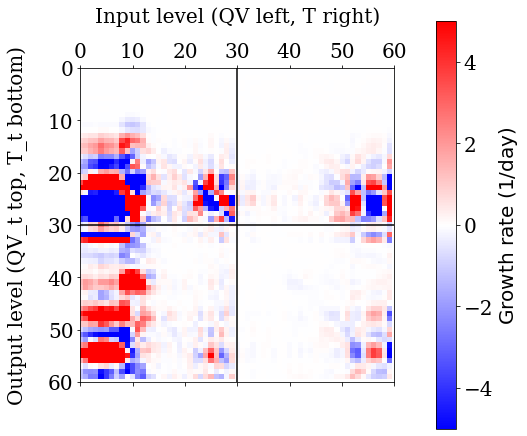

In [73]:
plt.rc('font', family='serif')

for ifig in range(2):
    plt.figure(num=None,dpi=80, facecolor='w', edgecolor='k')
    fig, ax = plt.subplots(figsize=(7.5,7.5))
    
    if ifig==0: toplot = 24*3600*LRFmean_stab; case = 'Stable'
    elif ifig==1: toplot = 24*3600*LRFmean_unstab; case = 'Unstable'
    print('Case #',ifig+1,case)
    cax = ax.matshow(toplot,cmap='bwr', vmin=-5, vmax=5)

    x = np.linspace(0.,60.,100);

    plt.plot(x,Np*x**0, color='k')
    plt.plot(Np*x**0,x, color='k')
    plt.xlim((0,2*Np)); plt.ylim((2*Np,0))

    cbar = fig.colorbar(cax, pad = 0.1)
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'$\mathrm{Growth\ rate\ \left(1/day\right)}$',\
                   rotation=90, fontsize = 20)

    plt.xticks(fontsize=20); plt.yticks(fontsize=20)
    ax.xaxis.set_label_position('top')
    X = plt.xlabel(r'Input level (QV left, T right)', fontsize = 20)
    ax.xaxis.labelpad = 20
    Y = plt.ylabel(r'Output level (QV_t top, T_t bottom)', fontsize = 20)
    ax.yaxis.labelpad = 20

# 4) Save profiles and linear reponse functions for Noah

Save four linear response functions:  
1) Mean LRF for stable NN  
2) Mean LRF for unstable NN  
3) LRF for stable NN about mean base state  
4) LRF for unstable NN about mean base state

In [74]:
Name = ['MeanLRF_stable','MeanLRF_unstable','LRFMean_stable','LRFMean_unstable']
jac = {}
for ijac,name in enumerate(Name):
    if ijac==0: tmp = LRFstab_mean
    elif ijac==1: tmp = LRFunstab_mean
    elif ijac==2: tmp = LRFmean_stab
    elif ijac==3: tmp = LRFmean_unstab
    
    jac[name] = {}
    jac[name]['q'] = {}
    jac[name]['T'] = {}
    jac[name]['q']['q'] = tmp[:30,:30]
    jac[name]['q']['T'] = tmp[:30,30:]
    jac[name]['T']['q'] = tmp[30:,:30]
    jac[name]['T']['T'] = tmp[30:,30:]

Take mean of pert_state (which should be close to base_state) for reference

In [75]:
pert_state_mean = {};

for i,profile in enumerate(profiles):
    print('i=',i,' profile=',profile,'          ',end='\r')
    pert_state_mean[profile] = np.mean(pert_state[profile],axis=1)

In [76]:
for i,scalar in enumerate(scalars):
    print('i=',i,' scalar=',scalar,'          ',end='\r')
    pert_state_mean[scalar] = np.mean(pert_state[scalar])

Save all LRFs, base state, and mean of perturbed states in an pkl file for Noah

In [77]:
path = '/home1/05823/tg851228/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

In [78]:
hf = open(path+'8_19_LRF.pkl','wb')
ForNoah = {"base_state" : base_state,
           "mean_pert_state" : pert_state_mean,
           "linear_response_functions" : jac}
pickle.dump(ForNoah,hf)
hf.close()

# 5) Eigenvalue analysis of LRFs

## 5.1) Coupled (T,q) system

Spectrum of all 4 LRFs  
Of course, note that for the mean LRFs, one could also take the mean of the spectrum

Text(0, 0.5, 'Eigenvalue [1/day]')

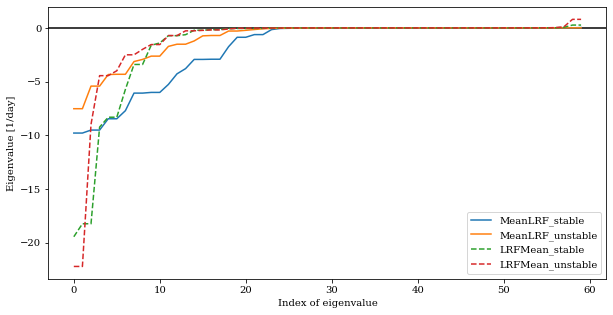

In [79]:
TQ_sp = {}

plt.figure(figsize=(10,5))
plt.axhline(y=0,color='k')

for ijac,name in enumerate(Name):
    if ijac==0: tmp = LRFstab_mean; ls = '-'
    elif ijac==1: tmp = LRFunstab_mean; ls = '-'
    elif ijac==2: tmp = LRFmean_stab; ls = '--'
    elif ijac==3: tmp = LRFmean_unstab; ls = '--'

    Eval, Evec = LA.eig(tmp)
    lam = 24*3600*np.real(Eval)
    TQ_sp[name] = [np.min(lam),np.max(lam)]
    plt.plot(np.sort(lam),label=name,linestyle=ls)

plt.legend()
plt.xlabel('Index of eigenvalue')
plt.ylabel('Eigenvalue [1/day]')

From this graph, and given that we may trust the spectrum of the smooth mean LRFs more than the spectrum of the noisy LRF about the mean base state, we can infer that:  
The instability may be caused by a lack of damping of multiple modes rather than an amplification of a single mode

## 5.2) (T,q) system coupled via WTG following Beucler and Cronin (2018)

Calculate ham coefficient for the base state

In [80]:
dq_dp = np.gradient(base_state['qv'],base_state['p'])
dT_dp = np.gradient(base_state['T'],base_state['p'])
dz_dp = np.gradient(base_state['z'],base_state['p'])
ham = -L_V*dq_dp/(C_P*dT_dp+G*dz_dp)

Text(0, 0.5, 'Pressure [hPa]')

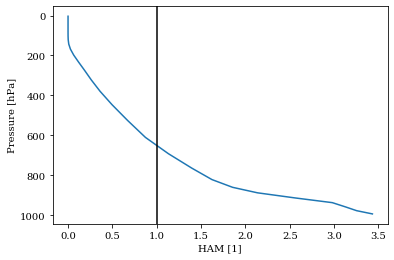

In [81]:
plt.plot(ham,base_state['p'])
plt.axvline(x=1,color='k')
plt.gca().invert_yaxis()
plt.xlabel('HAM [1]')
plt.ylabel('Pressure [hPa]')

In [82]:
def nearest_index(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

Text(0, 0.5, 'Eigenvalue [1/day]')

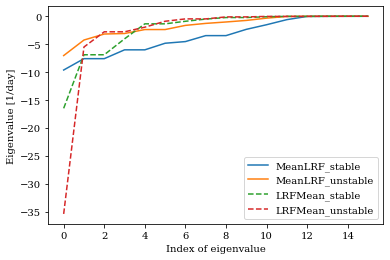

In [83]:
LS = ['-','-','--','--']
LRF_WTG = {}
WTG_sp = {}

i150 = nearest_index(base_state['p'],150)
i900 = nearest_index(base_state['p'],925)

for ijac,name in enumerate(Name):
    LRF_WTG[name] = jac[name]['q']['q']+(ham*C_P/L_V)*jac[name]['q']['q']
    Eval, Evec = LA.eig(LRF_WTG[name][i150:i900,i150:i900])
    lam = 24*3600*np.real(Eval)
    WTG_sp[name] = [np.min(lam),np.max(lam)]
    plt.plot(np.sort(lam),label=name,linestyle=LS[ijac])

plt.legend()
plt.xlabel('Index of eigenvalue')
plt.ylabel('Eigenvalue [1/day]')

This eigenvalue analysis is consistent with the one for the full (T,q) system: It is the lack of damping of the "unstable NN" that may be causing the instability rather than the positive eigenvalues at the end of the spectrum. The positive eigenvalues are not present in this analysis, suggesting that the positive modes may have been either BL or upper-atmospheric modes that we have filtered out here.